In [3]:
! git clone https://github.com/ageron/handson-ml2.git

fatal: destination path 'handson-ml2' already exists and is not an empty directory.


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [28]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [29]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [30]:
y.shape

(70000,)

In [31]:
28*28

784

Saving figure some_digit_plot


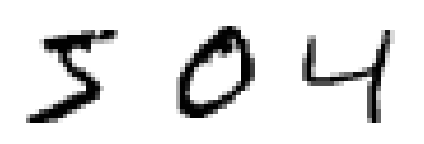

In [40]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.subplot(1,3,1)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis('off')

some_digit = X[1]
some_digit_image = some_digit.reshape(28,28)
plt.subplot(1,3,2)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis('off')

some_digit = X[2]
some_digit_image = some_digit.reshape(28,28)
plt.subplot(1,3,3)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis('off')

save_fig("some_digit_plot")
plt.show()

In [41]:
print(y[0],y[1], y[2])

5 0 4


In [45]:
y = y.astype(np.uint8)

In [46]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [47]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


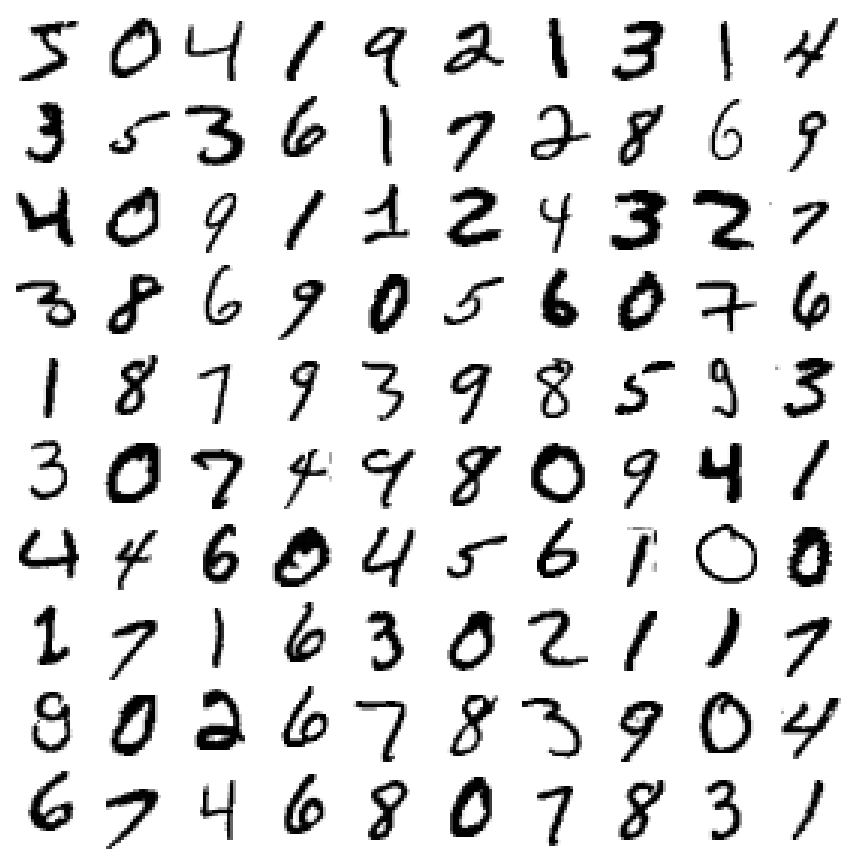

In [48]:

plt.figure(figsize=(12,12))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()


In [49]:
y[0]

5

In [51]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]

### Training a Binary Classifier

In [59]:
y_train_4 = (y_train == 4)
y_test_4 =  (y_test  == 4)

In [60]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-4, random_state = 42)
sgd_clf.fit(X_train, y_train_4) 

SGDClassifier(random_state=42, tol=0.0001)

In [61]:
sgd_clf.predict([some_digit])

array([ True])

In [80]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_4, cv = 3, scoring = "accuracy")

array([0.9671 , 0.97645, 0.9687 ])

### Performance Measures

#### Measuring Accuracy using Cross-validation

In [72]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_4):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_4[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_4[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9787
0.97745
0.97375


In [81]:
from sklearn.base import BaseEstimator
class Never4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

### Confusion Matrix

In [89]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv = 5)

In [90]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_4, y_train_pred)

array([[53283,   875],
       [  823,  5019]])

In [92]:
y_train_perfect_predictions = y_train_4
confusion_matrix(y_train_4, y_train_perfect_predictions)

array([[54158,     0],
       [    0,  5842]])

### Precision and Recall

In [93]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_4, y_train_pred)

0.8515439429928741

In [94]:
cm = confusion_matrix(y_train_4, y_train_pred)
cm[1,1]/ (cm[0,1] + cm[1,1])

0.8515439429928741

In [95]:
recall_score(y_train_4, y_train_pred)

0.8591235878123931

In [96]:
cm[1,1]/(cm[1,0] + cm[1,1])

0.8591235878123931

In [97]:
from sklearn.metrics import f1_score
f1_score(y_train_4, y_train_pred)

0.8553169734151329

In [102]:
cm[1,1]/(cm[1,1] + cm[1,0] + cm[0,1]/2)

0.7992674576001274

### Precision/ Recall Trade_off

In [103]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3214.66574913])

In [104]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)

In [105]:
y_some_digit_pred

array([ True])

In [106]:
threshold = 10000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [109]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3,
                            method = "decision_function")

In [110]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

Saving figure precision_recall_vs_threshold_plot


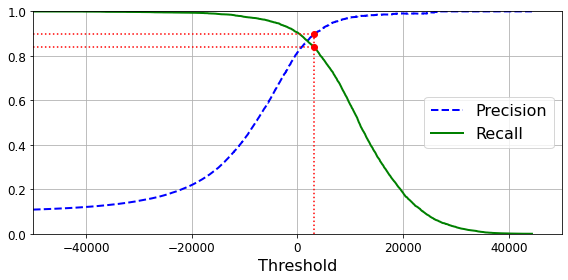

In [111]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [113]:
(y_train_pred == (y_scores>0)).all()

False

Saving figure precision_vs_recall_plot


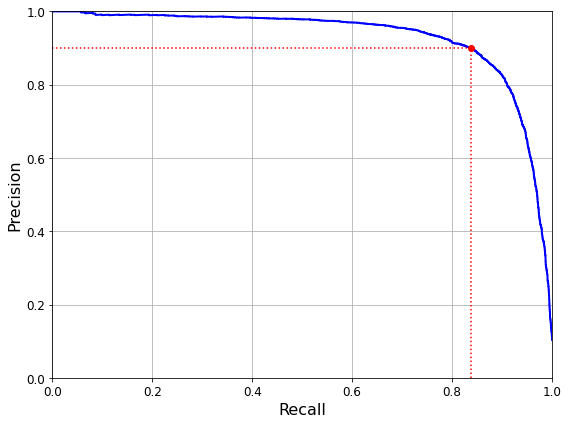

In [114]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [115]:
threshold_90_precision = thresholds[np.argmax(precisions >=0.90)]
threshold_90_precision

3196.99296946649

In [116]:
y_train_pred_90 = (y_scores >=threshold_90_precision)

In [117]:
precision_score(y_train_5, y_train_pred_90)

0.9001287474710318

In [118]:
recall_score(y_train_4, y_train_pred_90)

0.8377268058883944

### ROC Curve

In [119]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

Saving figure roc_curve_plot


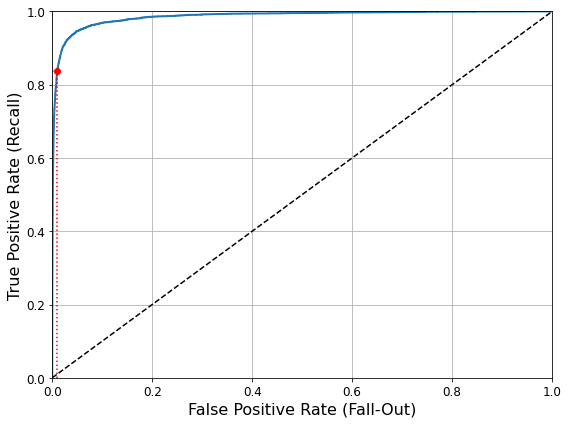

In [120]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [122]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_4, y_scores)

0.9859276923382874

In [123]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 50, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_4, cv= 3,
                                   method = "predict_proba")

In [124]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4, y_scores_forest)

Saving figure roc_curve_comparison_plot


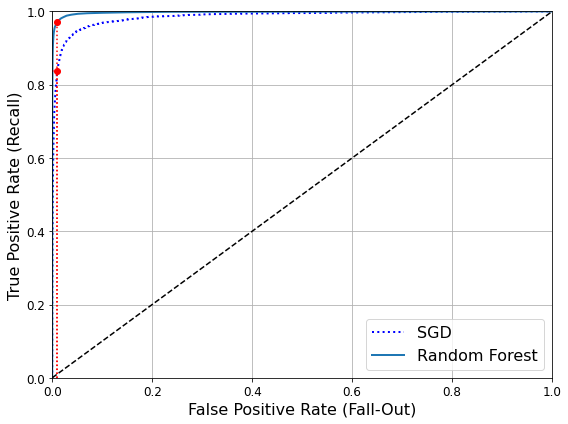

In [125]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [126]:
roc_auc_score(y_train_4, y_scores_forest)

0.997821572290057

In [127]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv = 3)
precision_score (y_train_4, y_train_pred_forest)

0.9906922629435718

In [128]:
recall_score(y_train_4, y_train_pred_forest)

0.8745292707976721

### Multiclass Classification

In [129]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = 'auto', random_state = 42)
svm_clf.fit(X_train[:1500], y_train[:1500])
svm_clf.predict([some_digit])

array([4], dtype=uint8)

In [131]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.80190842,  7.07289448,  4.81635068,  3.80878506,  9.29942989,
         0.79269095,  2.80529953,  8.11481481, -0.21544973,  5.86012912]])

In [132]:
np.argmax(some_digit_scores)

4

In [134]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [138]:
svm_clf.classes_[4]

4

In [139]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma = 'auto', random_state =42))
ovr_clf.fit(X_train[:1500], y_train[:1500])
ovr_clf.predict([some_digit])

array([4], dtype=uint8)

In [140]:
len(ovr_clf.estimators_)

10

In [141]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

In [142]:
sgd_clf.decision_function([some_digit])
np.argmax(sgd_clf.decision_function([some_digit]))

4

In [143]:
cross_val_score(sgd_clf,X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [156]:
sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_clf.fit(X_train, y_train_4) 

SGDClassifier(random_state=42)

In [157]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[:10000].astype(np.float64))
sgd_clf.fit(X_train_scaled, y_train[:10000])
# 컴퓨터가 안좋아, 계산시간이 너무 오래걸려서, 한타임으로 바꿨습니다!
# 또한, train size 도 10000개로 줄였습니다. (60000개에서)

SGDClassifier(random_state=42)

In [163]:
sgd_clf.score(X_train_scaled, y_train[:10000])

0.9414

### Error Analysis

In [167]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train[:10000], cv=3)


In [169]:
conf_mx = confusion_matrix(y_train[:10000], y_train_pred[:10000])
conf_mx

array([[ 961,    0,    4,    3,    2,   16,    6,    2,    7,    0],
       [   0, 1073,   10,    4,    1,   14,    0,    2,   22,    1],
       [   9,   16,  863,   13,    9,    7,   15,   11,   43,    5],
       [   8,   11,   26,  882,    0,   43,    4,   17,   25,   16],
       [   3,    4,   11,    5,  876,    5,   10,    9,   18,   39],
       [   7,    4,    9,   37,   17,  716,   15,    1,   46,   11],
       [  11,    4,   11,    0,    8,   16,  942,    2,   19,    1],
       [   5,    2,   12,   10,   10,    1,    1,  958,    8,   63],
       [   8,   16,   23,   16,    2,   18,   14,    4,  837,    6],
       [   7,    7,    9,   19,   24,    4,    0,   29,   20,  859]])

In [170]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


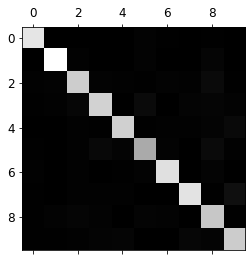

In [171]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [172]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


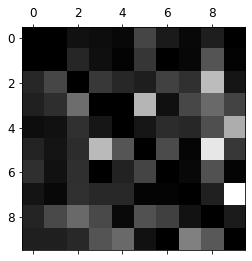

In [173]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [175]:
X_train_1 = X_train[:10000]
y_train_1 = y_train[:10000]

Saving figure error_analysis_digits_plot


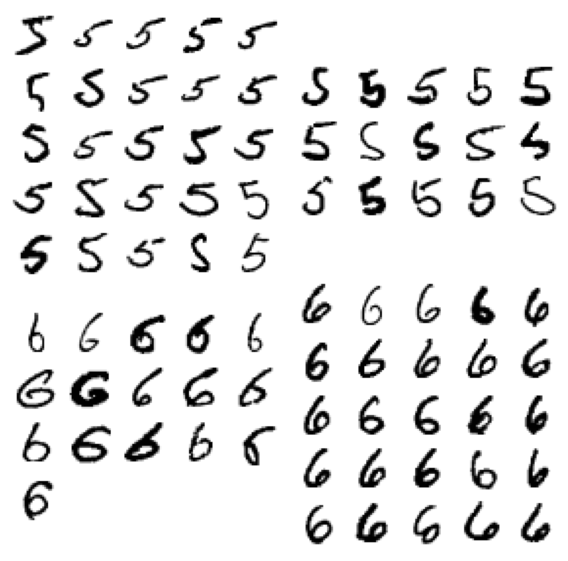

In [176]:
cl_a, cl_b = 5, 6
X_aa = X_train_1[(y_train_1 == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train_1[(y_train_1 == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train_1[(y_train_1 == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train_1[(y_train_1 == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

### Multilabel Classification

In [179]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=6)
y_train_even = (y_train%2 == 0)
y_multilabel = np.c_[y_train_large, y_train_even]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [180]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [181]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 2)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.9755680656569455

### Multiouput classification

In [182]:
noise = np.random.randint(0,50, (len(X_train), 784))
X_train_mod = X_train+noise
noise = np.random.randint(0,50, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

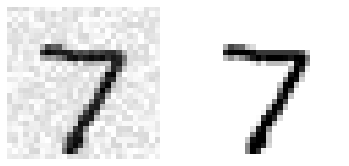

In [183]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

Saving figure cleaned_digit_example_plot


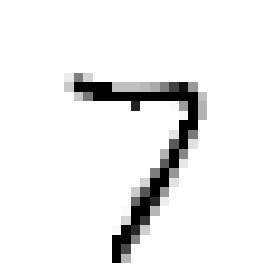

In [185]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

### Extra material

#### Dummy(ie. random) classifier

In [186]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy = 'prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_4, cv=2, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

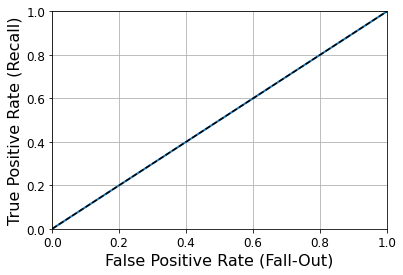

In [187]:
fprr, tprr, thresholdsr = roc_curve(y_train_4, y_scores_dmy)
plot_roc_curve(fprr, tprr)

### KNN classifier

In [188]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=3)
knn_clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3, weights='distance')

In [189]:
y_knn_pred = knn_clf.predict(X_test)

In [190]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)


0.9717

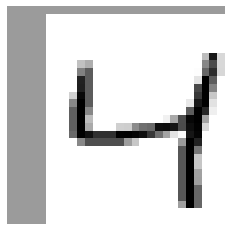

In [191]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))


In [192]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [193]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [194]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [195]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [196]:
ambiguous_digit = X_test[2489]
knn_clf.predict_proba([ambiguous_digit])

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

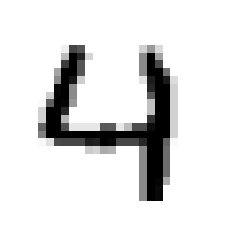

In [197]:
plot_digit(ambiguous_digit)

### Excercise 는 생략